## Import 

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras_lr_multiplier import LRMultiplier
from skimage import measure
import matplotlib.pyplot as plt
import PIL.Image as pilimg
import math
import prepare_sub_image as ps
import cv2
import numpy as np
from scipy import io
from collections import defaultdict

Using TensorFlow backend.


## Metrics

In [3]:
def psnr(target, ref):
    
    target_data = np.array(target, dtype = float)
    ref_data = np.array(ref, dtype = float)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = math.sqrt(np.mean(diff**2))
    
    return 20 * math.log10(255/rmse)

def ssim(target, ref):
    target_data = np.array(target)
    ref_data = np.array(ref)
    
    (score, diff) = measure.compare_ssim(target_data, ref_data, full = True, multichannel=True)
    
    return score

## Model

In [4]:
def model():
    
    
    SRCNN = Sequential()
    SRCNN.add(Conv2D(nb_filter = 64, nb_row = 9, nb_col = 9, init = 'glorot_uniform',
                    activation = 'relu', border_mode = 'same',bias_initializer = 'zeros',
                     input_shape = (None, None, 1), name = 'layer_1'))
    SRCNN.add(Conv2D(nb_filter = 32, nb_row = 5, nb_col = 5, init = 'glorot_uniform',
                    activation = 'relu', border_mode = 'same',bias_initializer = 'zeros', name = 'layer_2'))
    SRCNN.add(Conv2D(nb_filter = 1, nb_row = 5, nb_col = 5, init = 'glorot_uniform',
                    activation = 'linear', border_mode = 'same',bias_initializer = 'zeros', name = 'layer_3'))

    SRCNN.compile(optimizer = LRMultiplier(Adam(lr=0.0001), {'layer_1':1, 'layer_2':1, 'layer_3':0.1})
                                       , loss = 'mean_squared_error', metrics = ["mean_squared_error"]) 

    return SRCNN

## train & Predict

In [6]:
conv_side = 8
test_set = 'Set5'
scale = 3
#total_history = defaultdict(list)


def train():
    
    srcnn_model = model()
    srcnn_model.load_weights('checkpoint/SRCNN_checkpoint_scale3.h5')
    
    print(srcnn_model.summary())
    
    '''
    data, label = ps.read_training_data('training_sample/train_91_scale3.h5')
    val_data, val_label = ps.read_training_data('training_sample/cross_val_Set5_scale3.h5')
    '''
    
    PATH_image = '../Dataset/test/test_mat/{}/scale{}/'.format(test_set, scale)
    IMAGE_PATH = 'output_image/{}/scale{}'.format(test_set, scale)
    
    names_image = os.listdir(PATH_image)
    names_image = sorted(names_image)
    
    nums = len(names_image)
    
    count = 0
    global total_history
    
    checkpoint_filepath = 'checkpoint/SRCNN_checkpoint_scale3.h5'
    checkpoint_callbacks = [ModelCheckpoint(filepath = checkpoint_filepath, monitor = 'val_loss', verbose = 1, mode = 'min', 
                                            save_best_only = True)]
    
    
    for i in range(0,1):
        
        '''
        srcnn_model.fit(x = data, y = label, batch_size = 128, epochs = 50, verbose = 1,
                       callbacks = checkpoint_callbacks, validation_data = (val_data, val_label), shuffle = True)
        
        #srcnn_model.save('model_weight/SRCNN_check_91_scale3_same.h5')
        '''
        
        count += 1
        
        psnr_srcnn = []
        psnr_bicubic = []
        ssim_srcnn = []
        ssim_bicubic = []
        
        
        for i in range(nums):
            
            INPUT_NAME = IMAGE_PATH + '/' + 'input{}.jpg'.format(i)
            OUTPUT_NAME = IMAGE_PATH + '/' + 'predict{}.jpg'.format(i)

            mat_image = io.loadmat(PATH_image + names_image[i])
            
            hr_img = mat_image['im_hr_ycbcr']
            bicubic_img = mat_image['im_bicubic_ycbcr']
            
            hr_img_rgb = mat_image['im_hr_rgb']
            bicubic_img_rgb = mat_image['im_bicubic_rgb']
            
            hr_img_Y = hr_img[:, :, 0]
            bicubic_img_Y = bicubic_img[:, :, 0]
            
            
            shape = bicubic_img.shape

            input_Y = np.zeros([1, shape[0], shape[1], 1])
            input_Y[0, :, :, 0] = bicubic_img_Y / 255        
            
            pre = srcnn_model.predict(input_Y, batch_size = 1)        
            pre = pre * 255
            pre[pre[:] > 255] = 255
            pre[pre[:] < 0] = 0
            
            output_img = np.zeros([shape[0], shape[1], 3])
            output_img = output_img
            output_img[:, :, 0] = pre[0, :, :, 0]
            output_img[:, :, 2] = bicubic_img[:, :, 1]
            output_img[:, :, 1] = bicubic_img[:, :, 2]
            
            output_img_Y = output_img[:, :, 0]
            
            output_BGR = np.zeros([shape[0], shape[1], 3])
            
            output_BGR[:, :, 2] = 1.164 * (output_img[:, :, 0] - 16) + 1.596 * (output_img[:, :, 1] - 128)
            output_BGR[:, :, 1] = 1.164 * (output_img[:, :, 0] - 16) - 0.813 * (output_img[:, :, 1] - 128) - 0.392 * (output_img[:, :, 2] - 128)
            output_BGR[:, :, 0] = 1.164 * (output_img[:, :, 0] - 16) + 2.017 * (output_img[:, :, 2] - 128)
            
            cv2.imwrite(OUTPUT_NAME, output_BGR)
            
            '''
            # Measuring PSNR on RGB Channel
            output_img_rgb = np.zeros([shape[0], shape[1], 3])
            output_img_rgb[:, :, 0] = 1.164 * (output_img[:, :, 0] - 16) + 1.596 * (output_img[:, :, 1] - 128)
            output_img_rgb[:, :, 1] = 1.164 * (output_img[:, :, 0] - 16) - 0.813 * (output_img[:, :, 1] - 128) - 0.392 * (output_img[:, :, 2] - 128)
            output_img_rgb[:, :, 2] = 1.164 * (output_img[:, :, 0] - 16) + 2.017 * (output_img[:, :, 2] - 128)
            '''
            
            # Measuring PSNR on YCrCb Channel
            hr_img_measure = hr_img_Y[conv_side:-conv_side, conv_side:-conv_side]
            bicubic_img_measure = bicubic_img_Y[conv_side:-conv_side, conv_side:-conv_side]
            output_img_measure = output_img_Y[conv_side:-conv_side, conv_side:-conv_side]
            
            '''
            # Measuring PSNR on RGB Channel
            hr_img_measure = hr_img_rgb[conv_side:-conv_side, conv_side:-conv_side, :]
            bicubic_img_measure = bicubic_img_rgb[conv_side:-conv_side, conv_side:-conv_side, :]
            output_img_measure = output_img_rgb[conv_side:-conv_side, conv_side:-conv_side, :]
            '''

            psnr_bicubic_one = psnr(bicubic_img_measure, hr_img_measure)
            ssim_bicubic_one = ssim(bicubic_img_measure, hr_img_measure)

            psnr_srcnn_one = psnr(output_img_measure, hr_img_measure)
            ssim_srcnn_one = ssim(output_img_measure, hr_img_measure)
            
            print(i + 1)
            print('bicubic: ', psnr_bicubic_one, 'ssim: ', ssim_bicubic_one)
            print('srcnn: ', psnr_srcnn_one, 'ssim:', ssim_srcnn_one)


            psnr_bicubic.append(psnr_bicubic_one)
            ssim_bicubic.append(ssim_bicubic_one)

            psnr_srcnn.append(psnr_srcnn_one)
            ssim_srcnn.append(ssim_srcnn_one)


        psnr_bicubic_final = np.mean(psnr_bicubic)
        ssim_bicubic_final = np.mean(ssim_bicubic)

        psnr_srcnn_final = np.mean(psnr_srcnn)
        ssim_srcnn_final = np.mean(ssim_srcnn)
        
        print('Epochs: ', count)

        print('Bicubic')
        print('PSNR: ', psnr_bicubic_final, 'SSIM: ', ssim_bicubic_final)
        print('SRCNN')
        print('PSNR: ', psnr_srcnn_final, 'SSIM: ', ssim_srcnn_final)
        
        
        '''
        for key, value in history.history.items():

            total_history[key] = sum([total_history[key], history.history[key]], [])

            
        length = len(total_history['loss'])

        plt.plot(total_history['loss'])
        plt.plot(total_history['val_loss'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        #plt.xticks(ticks = 1)
        plt.xlim(9, length)
        plt.ylim(0, 0.003)
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        '''


if __name__ == "__main__":
    
    train()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Conv2D)             (None, None, None, 64)    5248      
_________________________________________________________________
layer_2 (Conv2D)             (None, None, None, 32)    51232     
_________________________________________________________________
layer_3 (Conv2D)             (None, None, None, 1)     801       
Total params: 57,281
Trainable params: 57,281
Non-trainable params: 0
_________________________________________________________________
None
1
bicubic:  33.85666956702801 ssim:  0.6248266818275703
srcnn:  35.028344721933905 ssim: 0.6697829386314973
2
bicubic:  32.6529694933143 ssim:  0.7342180441332782
srcnn:  35.432947252825414 ssim: 0.7606241615988635
3
bicubic:  24.0904924141445 ssim:  0.4844228767903819
srcnn:  28.314468783857794 ssim: 0.5879839274369222
4
bicubic:  32.789871497723084 ssim:  0.4448741278438

## Visualization 

In [ ]:
length = len(total_history['loss'])

plt.plot(total_history['loss'])
plt.plot(total_history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.xlim(9, length)
#plt.ylim(0.0002, 0.0004)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

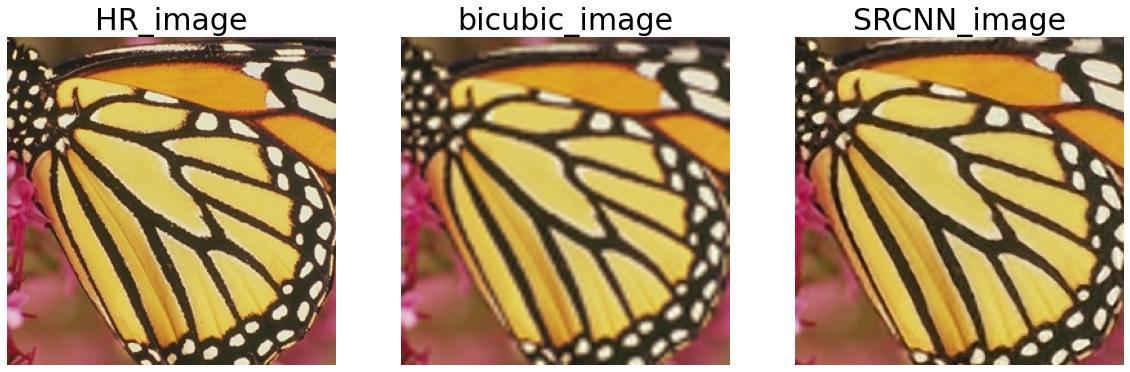

In [7]:
def visualization():
    
    hr_img = pilimg.open('../Dataset/test/test_image/{}/hr_rgb/scale{}/hr_RGB_{}_3.bmp'.format(test_set, scale, scale))
    pix_hr = np.array(hr_img)
    
    bicubic_img = pilimg.open('../Dataset/test/test_image/{}/bicubic_rgb/scale{}/bicubic_RGB_{}_3.bmp'.format(test_set, scale, scale))
    pix_bicubic = np.array(bicubic_img)
    
    srcnn_img = pilimg.open('output_image/{}/scale{}/predict2.jpg'.format(test_set, scale))
    pix_srcnn = np.array(srcnn_img)
    
    fig = plt.figure(figsize = (20,32))
    rows = 1
    cols = 3
    
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(hr_img)
    ax1.set_title('HR_image', size = 30)
    ax1.axis('off')
    
    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(bicubic_img)
    ax2.set_title('bicubic_image', size = 30)
    ax2.axis('off')
    
    ax3 = fig.add_subplot(rows, cols, 3)
    ax3.imshow(srcnn_img)
    ax3.set_title('SRCNN_image', size = 30)
    ax3.axis('off')
    
    plt.show()
    

if __name__ == "__main__":
    
    visualization()